In [1]:
from sklearn.model_selection import GridSearchCV
import numpy as np

X = np.load('data/X_train.npy')
y = np.genfromtxt('data/y_1.csv', delimiter='\n')
#data_test = np.load('data/X_test.npy')

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=610, hist_bins=None,
        images_x_from=False, images_x_to=False,
        images_y_from=False, images_y_to=False):

        self.splits = splits
        self.hist_bins = hist_bins

        self.images_x_from = images_x_from
        self.images_x_to = images_x_to
        self.images_y_from = images_y_from
        self.images_y_to = images_y_to

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [[1, 282.10434686113894, 528.4350826042349, 635.7632261805744, 781.9301580581496, 962.0317275933281, 1079.2939329789033, 1246.3707282050862, 1393.0345691835053, 1721.8292294917992]]
            self.hist_bins = [[1.0, 235.24866102437392, 555.10806045767185, 620.5717939683982, 757.70009508231635, 1048.0503974252849, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.88611185918899, 632.28590798140442, 737.64760569656619, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.23988224140624, 624.73118483342137, 767.10725854227485, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.83075036919661, 674.15022798621885, 816.13269538465306, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.4796322828511, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.86227251056528, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]
            
        first = True
        for row in X:
            # This is feature selection 
            if self.images_x_from is not False and self.images_x_to is not False:
                images = np.split(row, 176)[self.images_x_from : self.images_x_to]
                
                # x needs to be set for this, but don't mind at the moment
                if self.images_y_from is not False and self.images_y_to is not False:
                    images_new = []
                    for image in images:
                        images_new.append(np.split(image, 208)[self.images_y_from : self.images_y_to])
                    images = np.array(images_new)

                row = np.array(images).flatten()
                #features = []
                #for image in images:
                #    for split in np.array_split(image, 104):  
                #        features.append(np.histogram(split, bins=hist_bins, density=False)[0])
            #big_splits = np.array_split(row, len(self.splits))
            #splits = np.array([])
            #for i, s in enumerate(big_splits):
            #    small_split = np.array_split(row, int(len(s) / self.splits[i]))
            #    splits = np.concatenate((splits, small_split), axis=0)
                
            splits = np.array_split(row, int(len(row) / self.splits))
            if first:
                #print("splits: "+str(len(splits)))
                first = False
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])

            X_new.append(np.array(features).flatten())

        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
#from sklearn.decomposition import TruncatedSVD

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=610,
        images_x_from=50, images_x_to=125, images_y_from=None, images_y_to=None)), # was y_to=196, but worse score
    ('scaler', StandardScaler()),
    ('vct', VarianceThreshold(threshold=0.1)),
    #('linreg', LinearRegression(n_jobs=-1))
    ('linearSVR', LinearSVR(C=1.0, max_iter=1300))
    #('bagging', BaggingRegressor(LinearSVR(C=1.0, max_iter=2000), max_features=0.8, n_jobs=-1))
])

In [9]:
from ensemble import RandomEnsemble
from sklearn.metrics import mean_squared_error
#pipe = RandomEnsemble()
pipe.fit(X[0:150], y[0:150])
print('fitted')
y_pr = pipe.predict(X[151:228])
print(mean_squared_error(y[151:228], y_pr))

# 52.5900323473 var0.05 bins=10
# 51.6259478991 better bins 41k
# 51.3320775803 added 1-edges, 47k, /500
# 51.6 /300, 78k
# 52.2 /220, 106k
# 55.5 /64, 366k
# 51.1 linearsvr, /500, 53k
# 51.6 /510
# 51.5 /490
# 49.56 /1000, random bins
# 49.09 /610
# 49.08 C=15
# 49.0 max_iter=2000
# 48.99 variance threshold=0.2
# 47.39 better random bins again
# 47.17 y_to=204
# 46.938 x_to=132, (C=1, threshold=0.1)
# 46.936 linreg
# 46.81 x_to=125, y_to=196
# 45.96 better bins  --- splits "610" are 4500 splits really, but don't mind

# 47.18 bagging
# 47.86 RandomEnsemble
# 90.9 /250
# 51.7 /1000
# 52.0 add random edge, 58k
# 51.7 remove last edge, 47k
# 52.1 /125, 187k
# 52.8160909792 more better bins 99k
# 67.7           kernelridge
# 51.5455457395 much more bins 94k
# 51.5211591462 less bins 31k
# 51.6344647532 more bins 67k
# 56            more better bins 87k features
# 55.5 other splits2, 41k
# 52.6655238717 other splits, 28k features
# 56.237862326  14k features
# 52.1237605257  56k features

import os
os.system('say "i have finished!"')

fitted
46.1088162673


0

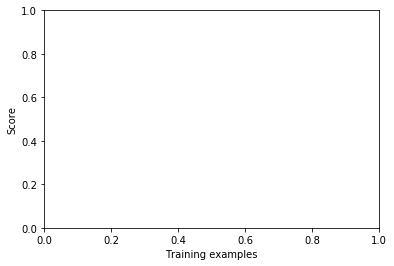

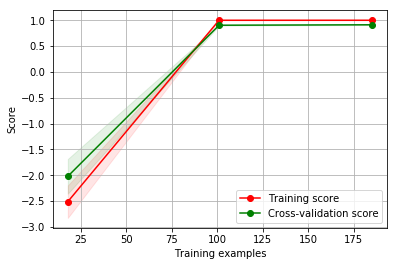

In [31]:
#grid.cv_results_
#grid.best_params_
#pipe.named_steps['vct'].variances_
#len(pipe.named_steps['vct'].get_support(True))

train_sizes=np.linspace(.1, 1.0, 4)

import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
plt.figure()
#plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    pipe, X, y, cv=3, n_jobs=-1, train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [4]:
# Search bin subdivision so that there is highest variance
# 1. Divide hist into bins over some rows
# 2. Compute std -> divide bins where it's high, join/drop those where it's low
# 3. Repeat / change rows
kmeans = KMeans(n_clusters=8, n_jobs=-1, random_state=42)

samples = X[0: 5]
centers = []
for i, sample in enumerate(samples):
    # sample = sample[1672390 : -786303]

    sample = sample[(sample > 0) & (sample < 1800)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))

    #samples[i] = sample
    #print(str(i) + ' done')

if True: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))

print('n edges: ' + str(len(edges)))
edges

n edges: 40


[array([  316.06548606,   516.04062473,   672.03912953,   788.4017923 ,
          912.68082233,  1063.06793716,  1221.11834124,  1370.37759073]),
 array([  308.77309614,   504.8323311 ,   661.04570736,   783.16988715,
          921.22162422,  1080.41577968,  1247.41710179,  1393.10546197]),
 array([  259.42693236,   454.41115039,   637.10735577,   783.24697727,
          918.05688785,  1076.03364154,  1238.7439229 ,  1383.01276065]),
 array([  284.2603614 ,   461.84852282,   647.97452156,   826.76038816,
          980.3224361 ,  1135.55237028,  1308.37312973,  1473.53302531]),
 array([  277.75613471,   482.81300987,   649.12127803,   776.62490065,
          913.78209436,  1076.42318956,  1235.8621241 ,  1375.33653253])]

In [ ]:
from sklearn.utils import resample

edges = [1,
 175, 190.0, 200, 210, 220, 230.0, 240, 250.29576676838963, 260.59153353677925, 270.7998907955566, 281.00824805433393, 296.51672876785585, 312.4192910985714, 328.7096455492857,
 345, 365.11915911105507, 385.23831822211014, 421.68407741265736, 458.1298366032046, 517.3519134270805, 576.5739902509565, 609.5574644576008, 626.0492015609229, 642.540938664245, 655.0834926946815, 666.5424184427528, 680, 688.7915018861073, 697.5830037722146, 705.1660075444291, 712.7490113166436, 720.3320150888583, 730.1660075444291, 740, 747.7243484748634, 755.4486969497268, 763.1730454245902, 770.8973938994536,
 778.3608893423097, 785.8243847851659, 792.7855130483395, 799.7466413115131, 807.5810902304434, 816.5985296073651, 825.6159689842868, 836.8877682054391, 848.1595674265914, 863.9400863362044, 879.7206052458175, 905.8611747488183, 932.0017442518191, 950.2522817644435, 968.5028192770679,
 995.0990029527295, 1021.6951866283912, 1045.622987987501, 1084.7830302704533, 1123.9430725534057, 1178.3353557602009, 1203.4127942147347, 1228.4902326692686, 1240.8414534419671, 1253.1926742146657, 1265.5438949873642, 1277.8951157600625, 1288.9475578800311, 1300, 1309.8438400564696, 1319.6876801129395,
 1329.5315201694093, 1339.375360225879, 1347.7457855765365, 1356.1162109271943, 1365.7868972366239, 1375.4575835460535, 1386.4285308142548, 1400, 1408.3298109092373, 1416.6596218184745, 1424.9894327277118, 1433.319243636949, 1442, 1448.5, 1461.25, 1470.625, 1480, 1490.0, 1500,1509.375,
 1518.75, 1530, 1546.25, 1562.5, 1581.25, 1610, 1700.0]
hists = []
for x in X:#resample(X, n_samples=100):
    hists.append(np.histogram(x, bins=edges)[0])
    
std_all = np.std(np.array(hists).flatten())
for bin_i in range(len(hists[0])):
    arr = [h[bin_i] for h in hists]
    print("bin "+str(bin_i)+": "+str(np.std(arr) / std_all))

In [ ]:
from IPython.display import display
new_edges = edges # attention: 49 bins = 50 edges
for i in range(1):
    # compute hists for samples
    hists = []
    for x in X:
        hists.append(np.histogram(x, bins=new_edges)[0])

    ed = [1]
    for bin_i in range(len(hists[0])):
        # compute std for bin i
        arr = [h[bin_i] for h in hists]
        std = np.std(arr) / std_all
        
        if std > 0.35: # if std over threshold, split bin
            ed.append(0.5 * (new_edges[bin_i] + new_edges[bin_i+1])) 
            
        if std < 0.2: # if std too low, join with next bin
            continue
            
        ed.append(new_edges[bin_i+1])
        
    new_edges = ed
    if len(new_edges)>=120: break
        
print(len(new_edges))
display(new_edges)

In [14]:
import random
from sklearn.metrics import mean_squared_error
def run(a, b):  
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=a, hist_bins=b,
        images_x_from=50, images_x_to=125, images_y_from=None, images_y_to=None)), # was y_to=196, but worse score
    ('scaler', StandardScaler()),
    ('vct', VarianceThreshold(threshold=0.1)),
    #('linreg', LinearRegression(n_jobs=-1))
    ('linearSVR', LinearSVR(C=1.0, max_iter=1000))
    ])

    pipe.fit(X[0:140], y[0:140])
    y_pr = pipe.predict(X[141:228])
    print("\x1b[1;31m%s\x1b[0m \t%s\t%s" % (mean_squared_error(y[141:228], y_pr), a, b))
    #print("\t", hist_bins)

In [15]:
some_bins = [  1.00000000e+00,   2.43148939e+02 ,  5.52670768e+02,   6.63323565e+02,   7.82650357e+02 ,  1.02133853e+03 ,  1.08620935e+03,   1.20392913e+03,   1.39695300e+03 ,  1.75176484e+03]
binss = [[1.0, 235.24866102437392, 555.10806045767185, 620.5717939683982, 757.70009508231635, 1048.0503974252849, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.88611185918899, 632.28590798140442, 737.64760569656619, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.23988224140624, 624.73118483342137, 767.10725854227485, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.83075036919661, 674.15022798621885, 816.13269538465306, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.4796322828511, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.86227251056528, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]
"""
for i in range(550, 800, 20):
    try:
        run([i, 610, 610], [some_bins])
    except:
        pass
"""

def random_bins(bb):
    new_bins = [1]
    for j in range(1, len(bb)):
        b = bb[j]
        new_bins.append(random.uniform(b - 100, b + 100))
    return list(np.sort(new_bins))

run(610, binss) # reference score
for i in range(0, 150):
    bins = []
    #bins.append(random_bins(binss[0]))
    bins.append(random_bins(binss[0]))
    
    #bins.append(random_bins(binss[1]))
    bins.append(random_bins(binss[1]))
    
    #bins.append(random_bins(binss[2]))
    bins.append(random_bins(binss[2]))
    
    #bins.append(random_bins(binss[3]))
    bins.append(random_bins(binss[3]))
    
    #bins.append(random_bins(binss[4]))
    bins.append(random_bins(binss[4]))
    
    run(610, bins)   


49.6521309763 	610	[[1.0, 235.24866102437392, 555.1080604576719, 620.5717939683982, 757.7000950823164, 1048.050397425285, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.886111859189, 632.2859079814044, 737.6476056965662, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.2398822414062, 624.7311848334214, 767.1072585422748, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.8307503691966, 674.1502279862189, 816.1326953846531, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.479632282851, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.8622725105653, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]
53.3276739528 	610	[[1.0, 142.66109481224493, 459.76882951969503, 615

52.717103733 	610	[[1.0, 222.41814146881228, 593.48310558437743, 715.10362321670152, 731.65319388185685, 1032.8002801804885, 1144.8443868316385, 1226.3728657600504, 1507.160796035037, 1657.2895472856624], [1.0, 239.38798137635618, 570.56602364653259, 586.94012553926507, 686.34259636787863, 1006.9732355534396, 1086.6881269262558, 1211.4543735458446, 1292.9383511691829, 1834.7506152799549], [1.0, 246.95176260760357, 523.86070856420747, 613.18416723699158, 756.04804812560121, 888.93927712368918, 1095.4942247031004, 1115.4562443109394, 1368.8770943339873, 1843.6612234596764], [1.0, 152.33040818961473, 578.74418508603026, 754.56993797719588, 856.9222674470866, 994.46127247862228, 1149.9064959029276, 1157.9893092394836, 1483.7541010552341, 1776.5908745613772], [1.0, 278.04570458915356, 552.08596682232087, 579.12988356669211, 712.16928995370984, 1025.8874744303826, 1088.440153619159, 1246.0314290380024, 1337.7814566696393, 1711.1779589096473]]
50.9322395791 	610	[[1.0, 334.47227267030627, 472

52.24310813 	610	[[1.0, 191.72139877125628, 594.33057841175685, 618.09743223099622, 694.93730819855318, 1036.4843947418919, 1083.3493371761208, 1133.1579548773668, 1455.214225810688, 1734.3911015113356], [1.0, 99.88609698244754, 414.62244984129205, 639.47444510945263, 655.68377202471709, 922.24147491275937, 1149.933668859514, 1336.6460334788969, 1414.7914802207745, 1844.221267422532], [1.0, 260.68206698018287, 525.43775643462425, 660.50613962394209, 741.64140854508605, 958.64449369189231, 1034.5334431325241, 1133.8837855557942, 1356.1735680096324, 1844.861462635675], [1.0, 285.74328408170607, 610.24404525868522, 652.1725547645666, 836.74202923937924, 955.45344017693174, 1033.8362138757761, 1268.0295823728802, 1392.183678768826, 1673.1554878061863], [1.0, 267.48862400657708, 562.62601936007161, 667.08837438217006, 677.15327172054197, 1011.1642898132274, 1076.4349853909259, 1105.1487992537013, 1296.1465398738667, 1780.7105273557804]]
53.1007467345 	610	[[1.0, 245.91105169035035, 599.8927

49.9380367846 	610	[[1.0, 288.79065172304161, 468.55603559399134, 636.11603073341234, 690.52231751914417, 1122.0968891721936, 1128.3499613416691, 1234.7357021198, 1435.4117417037698, 1684.9137709792262], [1.0, 162.3711067394274, 596.25518025692293, 667.29070578845847, 709.7348352313827, 916.20326998030441, 1094.3298801046778, 1203.528632880955, 1378.8368858444055, 1782.403629579687], [1.0, 210.08662046580889, 496.36338285858335, 625.67144676108455, 847.79358765831944, 978.04572306349951, 997.71737971145365, 1107.1596375486276, 1485.2102470444111, 1833.5060703112695], [1.0, 161.03226533523292, 527.70042925237567, 750.90081765676996, 802.11048674082951, 951.92797327909409, 1138.6863543266402, 1203.5534809772728, 1382.6126280849996, 1692.9904676912747], [1.0, 299.60414102508332, 513.28158030670477, 584.79726852761667, 854.74332812259445, 1030.4301337421396, 1138.1385975161324, 1181.2130866124114, 1279.3375734046333, 1621.1185857229038]]
49.689917396 	610	[[1.0, 310.46344670268621, 523.983

52.6246490227 	610	[[1.0, 173.41966821319085, 594.89648340727535, 652.80482751428701, 715.50883814939482, 962.81994270241375, 1115.4464123003327, 1131.5039162246421, 1415.1033983072148, 1693.9889236039264], [1.0, 242.85643463380089, 523.84048184236951, 678.34630260614426, 829.12789196036681, 966.36513849810797, 1030.9377364602922, 1343.0829436535944, 1349.5306108098173, 1737.2099919106518], [1.0, 183.16006170912658, 599.51435610942372, 645.62104969716972, 675.57579819884074, 971.43853364155859, 1008.6774304169398, 1164.112748114148, 1295.1287204440926, 1856.6421052287812], [1.0, 276.15633955789781, 549.77895772130103, 654.15318913215538, 743.19531091767294, 949.01640787764586, 1098.4824661426546, 1098.5297000395105, 1371.5238499992845, 1834.4109566013735], [1.0, 367.98964927426721, 571.32256068293168, 638.58616451013984, 724.38546748699332, 1027.2891527285099, 1090.6726611616591, 1156.5318919026508, 1431.0677443342965, 1762.50151167991]]
52.7808186722 	610	[[1.0, 200.09091917268984, 56

51.6881198628 	610	[[1.0, 181.77990711096709, 599.90843120327804, 683.07730754065619, 797.13960797363416, 1046.6921251999795, 1088.1606733646413, 1237.6689642813878, 1398.1570384135196, 1675.6570709916177], [1.0, 136.91064063807801, 511.21185373390165, 602.75799595325452, 710.16117090986654, 1044.2856669262653, 1138.0443196234235, 1205.7100907789288, 1307.0690560474877, 1856.1084527825469], [1.0, 154.75989647722875, 552.17937813457036, 600.02879798987624, 754.16399005857397, 1084.2695902548251, 1099.1673106636395, 1230.4717148206337, 1437.5063436560956, 1839.778178808672], [1.0, 224.58895023528004, 601.13952688950121, 724.14259524216379, 734.97100733588059, 975.79422652368396, 1016.7901944299352, 1136.3260982188035, 1294.5456724696883, 1678.4674596859506], [1.0, 263.05101230993125, 602.44658614935554, 618.07083620569188, 662.42555669213061, 1105.4277872879929, 1125.5131572433743, 1172.746643197406, 1334.8378696395087, 1614.3273740655225]]
53.2405422887 	610	[[1.0, 148.22762305078624, 5

51.2243095846 	610	[[1.0, 138.74603565478546, 619.72115861767702, 675.08017163654677, 812.22850684611581, 1105.6178100689333, 1127.4945841400006, 1186.4323825994918, 1519.3977883842988, 1770.5255653878371], [1.0, 155.15128260355425, 475.08334951379538, 549.45353773916588, 810.27825448680051, 925.54831719894037, 989.49287082412536, 1270.701484470889, 1400.7227456065768, 1760.8511646733257], [1.0, 191.14957407772323, 509.64332833853734, 558.4831578777264, 787.12755707317672, 1003.4301510585699, 1051.854754943311, 1101.1396157274842, 1397.1902529168644, 1814.9537301190719], [1.0, 213.41412355230929, 603.2605116150396, 690.26346261988226, 791.40983371342907, 1023.126301731111, 1115.3275761733169, 1163.952656835027, 1449.9772506719496, 1799.7449105529354], [1.0, 326.60645768882955, 417.4921629900075, 659.48169723126512, 728.17001819699612, 1021.3326222835258, 1051.343560655165, 1144.6065940751466, 1349.4640838918469, 1730.8584123048245]]
50.9738472803 	610	[[1.0, 197.98145765219016, 461.215

53.0019321888 	610	[[1.0, 313.85549738641424, 623.95737655192784, 705.39992432934059, 771.29664048568895, 1099.3849439078469, 1163.3479528905104, 1167.6141957305069, 1422.4483639355906, 1798.8590910542921], [1.0, 126.95708600441787, 498.00535944760378, 683.73956473497935, 830.97414707149073, 929.93891644272401, 1028.1012439712667, 1229.9472712119039, 1284.3221068530522, 1664.00459808045], [1.0, 166.80100184034339, 599.86143973348294, 600.86873391406903, 724.25432958343356, 1005.8518603342707, 1059.8126847898707, 1176.7494339020757, 1453.359955384904, 1829.314650147197], [1.0, 239.63163069214275, 578.14734400401233, 619.42800057786121, 823.4575636202228, 989.70320309782733, 1113.4137684262337, 1117.2914729586746, 1422.3083220637927, 1771.8587239436617], [1.0, 237.69129083011376, 580.02963117005174, 666.1958365771643, 830.41067847290788, 1042.3396155913522, 1055.8573946181332, 1164.2278675975303, 1298.3511450752715, 1772.1225876408655]]
53.218094608 	610	[[1.0, 296.40683188508694, 516.47

52.8052853641 	610	[[1.0, 306.02467752706968, 564.86134019492908, 593.51101148297096, 789.54649132582074, 1111.8421705198361, 1113.331449627723, 1136.4696643192694, 1390.3448025645612, 1686.8264102819803], [1.0, 183.35022122980658, 546.81561657875613, 556.12301975419439, 713.44667895258294, 1078.6516880713084, 1153.6146097453748, 1320.794764517819, 1435.4379357832804, 1797.5642132105681], [1.0, 251.61400824343127, 508.36254112961194, 691.35624106789919, 781.06561540484938, 1020.0952873097325, 1034.6254437508039, 1097.7072943806243, 1365.6088459993421, 1747.8416805166855], [1.0, 138.07413795487065, 618.46026228978394, 648.18542312790112, 895.86924032881006, 999.86490743896366, 1079.9838403607616, 1271.5457802957835, 1313.3504071638365, 1847.2802600660445], [1.0, 216.57607320841797, 595.31066978751096, 693.25474868936817, 711.43065008938527, 1052.6857992224263, 1058.5014839969074, 1183.2982969789948, 1289.1023702997736, 1643.872125661157]]
51.1570079774 	610	[[1.0, 186.51797294044911, 61

51.9869962892 	610	[[1.0, 247.70572346965378, 652.2704198365559, 706.52290916661639, 719.8802923985719, 1079.1459353394648, 1110.2442301794395, 1134.3437957576978, 1427.5984840625626, 1707.9374577727885], [1.0, 118.58269315286529, 533.35877159003599, 681.95688223281479, 750.74967104154268, 969.686696272169, 1013.4480492281663, 1224.9904662590575, 1450.6873726819904, 1777.2926246761581], [1.0, 245.75130777508235, 580.14153968980486, 688.25440083977196, 808.13910600131703, 1005.5180964372581, 1039.4972344158321, 1176.1162174829785, 1400.3008460453868, 1786.294212931045], [1.0, 254.26602706931851, 552.09483842648137, 723.00243745454793, 793.51592804217921, 986.56802983715272, 1059.4708007721476, 1224.9301074003536, 1336.8737591251704, 1694.1954876375532], [1.0, 359.39087938282694, 447.03594442951004, 699.7521684850384, 786.4820875391747, 1037.5722884699239, 1053.312885108186, 1192.4895064102748, 1250.3103500252259, 1781.6426108953149]]
53.3293911883 	610	[[1.0, 191.04550141131989, 527.012

51.278957607 	610	[[1.0, 160.70178627981625, 504.04921460044318, 616.16065887910281, 783.51548093195913, 1001.3941266914743, 1092.2561521968455, 1238.8044045576669, 1403.0568502766228, 1608.8368965941249], [1.0, 291.41800766826998, 608.07362752595532, 608.72372736838145, 813.71358309426182, 911.03608983650406, 1026.1999825606008, 1344.643901348084, 1396.4510552711172, 1746.973052422599], [1.0, 287.63754138677518, 542.7904676032133, 653.3924090341477, 799.40465420162377, 968.33932569527008, 1078.6710770007278, 1159.1418025662022, 1351.4412170741234, 1780.3536791877536], [1.0, 181.79094819271995, 522.34450475875235, 771.83277519705666, 894.11288135664495, 1012.2551167651236, 1133.9035704881298, 1275.3789798235985, 1286.1719452862214, 1804.9021463948932], [1.0, 174.58308533289693, 511.04572653975089, 604.18338300559617, 707.57351409128535, 1056.9819934798024, 1150.6927702035309, 1200.9994290473674, 1339.9361371514835, 1766.9024597858242]]
53.4923624785 	610	[[1.0, 323.61751345512499, 615.

53.5301757916 	610	[[1.0, 248.82455675184696, 565.04777797121483, 650.50791031880044, 788.66756860723967, 1066.0365136870355, 1098.8398401479376, 1227.7999854120371, 1340.2743522150899, 1658.8509231487483], [1.0, 203.17868946687841, 560.79910822996101, 574.77796833240029, 811.12706986011699, 915.58819622112935, 1100.7869887518373, 1274.8775241689789, 1468.1586781335798, 1855.8837462390577], [1.0, 213.6620499021904, 566.2776702776971, 644.99011798305344, 749.53128562601762, 1050.3114606223173, 1076.9118069084591, 1174.6007841804314, 1485.2248793963008, 1829.2425393524804], [1.0, 150.37873063099175, 555.1203286735647, 628.13552424813463, 904.60400748975644, 1027.6119254953171, 1053.415730081364, 1098.6458664181805, 1330.3032900579005, 1846.3071030748354], [1.0, 258.31712316636333, 541.36882279850943, 658.9304882728527, 734.59036770952116, 960.62291179515455, 1121.8027604344029, 1195.1751207981538, 1386.2904402293611, 1643.5862011786649]]
51.7454332162 	610	[[1.0, 229.01282703189423, 468.

52.3723699331 	610	[[1.0, 274.5450835199432, 578.13590260628371, 635.80971328503733, 774.44876325155712, 1107.8015181004644, 1129.4009646509662, 1266.5980131556573, 1387.6004487898128, 1802.9538679172742], [1.0, 244.04698766519562, 493.39181767947167, 644.67336870605379, 655.96046084890554, 1031.5500316380299, 1155.7862274210647, 1329.0371454604485, 1463.3987254407298, 1673.3338659299939], [1.0, 304.98009703757214, 479.85484372805473, 684.09003134891793, 698.94307852132147, 1005.0200392215361, 1103.3256715840221, 1129.360149016723, 1490.9622600700181, 1871.7638371264547], [1.0, 210.29452591061346, 446.132440430798, 724.04021602774765, 853.79949523460652, 951.78716936923149, 1026.3391038054156, 1113.754880345037, 1371.2435243138991, 1822.7144946216824], [1.0, 209.28781497404449, 497.88371890366147, 643.1193466479433, 850.24708613373502, 1028.0988568440621, 1137.1843566468747, 1240.2002494149247, 1347.9749526454375, 1686.5935230243499]]
53.2897231734 	610	[[1.0, 148.0640561116673, 648.11

51.674759099 	610	[[1.0, 172.15071200980049, 515.28521776790944, 613.66874382023252, 790.59049667160946, 1003.8618737284443, 1015.3890661295893, 1096.9866395952768, 1380.0357238522499, 1609.3099578167862], [1.0, 100.9918624526026, 521.13863335212727, 636.86417880633428, 696.13717982603657, 975.12987529895281, 1089.8338419415093, 1273.956915602216, 1346.983009290313, 1855.2118585538087], [1.0, 176.25204748456909, 547.31181738649809, 668.53770644876613, 686.22544479494331, 1040.494501611302, 1082.7354795528324, 1208.3531371572217, 1477.0772575331046, 1885.0913540917927], [1.0, 111.75734306791399, 533.74022569451927, 609.85570731080611, 808.90493524532837, 1078.1785482149162, 1148.5720341602255, 1156.6541741909468, 1330.688125383869, 1663.9664632371182], [1.0, 356.95055254251349, 554.92346982899221, 555.9057455623373, 707.51030905921073, 1069.5166147571031, 1148.4675201595853, 1176.0468185222771, 1330.5331700344686, 1650.9095354008914]]
52.511910583 	610	[[1.0, 225.7257361259264, 479.3668

54.9259879069 	610	[[1.0, 305.04655770114636, 619.17744525469288, 640.26108370699728, 780.04258804901917, 1029.9210650697021, 1035.450129292263, 1119.2058778440874, 1358.8348089648609, 1678.9620682590644], [1.0, 253.19212814154142, 580.36029860104713, 691.78807917063182, 705.53786455942372, 1050.1183721870871, 1052.8618609254027, 1240.1850262946277, 1424.3159367660571, 1707.9162705165213], [1.0, 300.22341313839883, 668.02043769875354, 668.78693338912183, 699.07573627251986, 983.36879781877758, 1055.4029268695649, 1228.7915545729356, 1472.5218456588964, 1871.0669671183759], [1.0, 172.35592783275328, 520.73403324587628, 581.50860695832159, 823.33681636582037, 996.11543651896181, 1052.1879375505166, 1157.0857216614233, 1339.8753467515182, 1855.1672315935473], [1.0, 202.21956581431834, 469.07327650785487, 554.24372237450632, 791.20862818114131, 946.11964746962099, 1150.1237458793573, 1192.3964805921441, 1283.2623208968766, 1705.5416239429571]]
53.0672469901 	610	[[1.0, 251.71194124901609, 

52.3849594353 	610	[[1.0, 306.66494545563199, 519.48650083400219, 546.50602904551442, 681.00213424219044, 961.34662842635487, 1056.8034948399124, 1269.3355552545979, 1359.7362376055812, 1623.8467099501602], [1.0, 166.58409227626652, 538.9866921653545, 652.91389569205421, 659.37903145368603, 1062.2595566494306, 1133.7255438833927, 1257.8108583813348, 1421.7467844839957, 1680.8686354791193], [1.0, 239.0276276086328, 524.66630075982391, 614.91635262567968, 832.39977932575778, 962.23222232870569, 1103.7448650411031, 1117.9254275224957, 1331.0900630398335, 1877.2035747793532], [1.0, 191.57446301538971, 537.23746750681289, 750.47217358498415, 780.48520218781573, 995.77985843894169, 1016.1562264530903, 1141.6082487159647, 1448.7566199502985, 1742.9657988278993], [1.0, 360.33568870496174, 527.17501465139867, 653.54859432740341, 846.0290765895337, 1121.3423016211893, 1159.7513019815692, 1232.4923987830189, 1428.1904544554752, 1694.5933637030789]]
52.734435834 	610	[[1.0, 181.66023831393247, 497

54.25403256 	610	[[1.0, 324.21223859279399, 546.74259572343465, 665.52357791660756, 853.90322253606723, 956.75576993125037, 1006.667139831879, 1099.0951249971226, 1502.4613152579755, 1740.250498298391], [1.0, 264.16802985532274, 473.5465606698275, 673.25303872609027, 703.89087273936548, 919.56431478068168, 1156.9596609051468, 1274.6596320116221, 1300.1862784466448, 1759.2528010410135], [1.0, 307.88970647741144, 563.126483174756, 573.26987735198963, 783.45406258467165, 1068.7406131242578, 1123.4735954358734, 1188.7386677549525, 1302.7617657276328, 1713.7929215910904], [1.0, 128.37749796167455, 572.25239725364338, 633.11539330833159, 737.25292411943713, 999.20624601251882, 1076.9668397870587, 1146.6640238628438, 1476.1930115131418, 1748.8975929192518], [1.0, 274.55398954108415, 523.25756345958268, 722.47430459080465, 786.57922913310517, 1070.3520899669177, 1107.0994685631842, 1172.2573699459049, 1375.9932136611212, 1659.4099901786099]]
52.9185640547 	610	[[1.0, 145.39790903767272, 498.25

46.2502180111 	610	[[1.0, 235.24866102437392, 555.10806045767185, 620.5717939683982, 757.70009508231635, 1048.0503974252849, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.88611185918899, 632.28590798140442, 737.64760569656619, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.23988224140624, 624.73118483342137, 767.10725854227485, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.83075036919661, 674.15022798621885, 816.13269538465306, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.4796322828511, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.86227251056528, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]

46.8002965385 	610	[[1.0, 218.55506230929186, 586.75418437206781, 652.2394559820674, 773.8961704594326, 1070.3001532069275, 1132.0119600739936, 1184.2612806674767, 1346.9641002898002, 1718.9557380387023], [1.0, 290.69893927293026, 572.90674625326255, 636.50257766581979, 823.0771012780242, 1059.0456553618278, 1107.4247015526541, 1155.7078943964748, 1399.8097447227119, 1724.0035902340619], [1.0, 218.72954212410218, 542.01253539936533, 653.43333213996402, 821.07268841149516, 1008.7924651333656, 1052.8010062125443, 1169.5052456580929, 1393.3189036641181, 1729.5274681498695], [1.0, 277.08527226987928, 565.65467450638698, 686.47530217708209, 750.38473433034494, 1028.017525595182, 1105.2834708322937, 1158.7544772919573, 1386.8471781779679, 1768.5751652257886], [1.0, 208.48377822151147, 598.37983146074566, 634.52319035808785, 744.42188750405739, 1040.1030410463857, 1134.7469964800446, 1231.2439735529522, 1400.1500086069593, 1734.6145682992137]]

49.0396154526 	610	[[1.0, 243.148939, 552.670768, 663.323565, 782.650357, 1021.33853, 1086.20935, 1203.92913, 1396.953, 1751.76484], [1.0, 169.07888603029684, 476.3993832496185, 659.11986598803605, 833.79724742451754, 954.32415399945558, 1074.2765867000755, 1137.6921525931543, 1366.5221080300698, 1672.6717108194036], [1.0, 243.148939, 552.670768, 663.323565, 782.650357, 1021.33853, 1086.20935, 1203.92913, 1396.953, 1751.76484]]

48.7184635539 	610	[[1.0, 243.148939, 552.670768, 663.323565, 782.650357, 1021.33853, 1086.20935, 1203.92913, 1396.953, 1751.76484], [1.0, 209.35283091979062, 536.59779906296069, 665.28712643428412, 846.84903546339149, 977.79123010728188, 1090.068463939142, 1282.5916662093121, 1350.8990626146378, 1775.4138020921694], [1.0, 189.36260739832539, 563.41978511220316, 652.87738609203211, 793.14021532167249, 945.93292735133036, 1038.5351281645719, 1268.0203915696984, 1345.7126149793392, 1719.8402573532387], [1.0, 321.42123027902852, 513.40658875027952, 676.08423490399321, 771.55097096222892, 941.85367259894826, 1109.1807381440169, 1204.4056231152172, 1466.8640638996865, 1828.0303138977495], [1.0, 174.99250489989211, 566.78723432351444, 637.93448070218324, 723.7844766038387, 1020.7683940864266, 1088.0469595895363, 1204.2431024253162, 1354.1723380995209, 1763.4259373890307]]

47.6369255523 	610	[[1.0, 150.56137278787102, 457.33153706202313, 658.06894123504503, 846.58397003064692, 937.57055999931936, 1071.2933958750946, 1121.1329082414429, 1358.9143850375874, 1652.8984285242545], [1.0, 209.08847589309377, 557.35118459195758, 603.4824475881037, 840.09353019069886, 932.41851138730772, 1028.4963859465074, 1155.4444447957785, 1377.7665328071323, 1804.5238259461053], [1.0, 213.9106433574936, 591.67054972204392, 708.8357454735019, 747.76344324889669, 1094.1244196827156, 1106.1429563548058, 1253.3733914174486, 1418.5599131213776, 1733.4247323867448], [1.0, 162.44558827529511, 481.40325003988937, 598.15057979065659, 718.17945850568867, 950.44081956361697, 1027.7252142536861, 1216.1222768235052, 1451.0664305285418, 1811.3579605658706], [1.0, 312.37402267538255, 476.11342209986088, 719.84074466372897, 727.79325764999419, 935.81641849656705, 1043.7522060542294, 1221.0676377127122, 1306.4885292222425, 1695.0292713230729]]

52.6312906266 	610	[[1.0, 189.5503242912886, 537.61680229523279, 661.83855088542248, 802.02238585544001, 1089.4436739018056, 1104.7103372201052, 1203.9346157852151, 1439.1054376802001, 1715.2109418204398], [1.0, 257.08440054471873, 601.16123993303529, 630.945429072362, 763.43839902428442, 1070.8992572405045, 1104.1228884369598, 1176.2280526906006, 1378.3535938502205, 1715.3140125331508], [1.0, 181.37696696183295, 471.71735456664578, 586.86512054883895, 741.04108090094758, 1046.1274691025374, 1068.8385874678852, 1279.6425439796981, 1339.7434326943328, 1742.3807154403535], [1.0, 242.49799087029592, 527.75976847519109, 654.95633684546453, 717.2060937026539, 1017.4194769917261, 1047.3483273516831, 1216.1081316498964, 1338.2020696090433, 1727.0440044327675], [1.0, 181.92948717846869, 564.34060552941673, 661.48347924277846, 771.58685260861591, 972.83035624273862, 1080.8682734200127, 1222.188461267657, 1368.0888213132946, 1837.9682744390957], [1.0, 270.86026560996629, 560.41396158106988, 581.04266274916552, 785.21051320219874, 1027.4738556561463, 1053.4880107751969, 1161.3082325515952, 1365.8816944637892, 1758.5421910238231], [1.0, 212.28250929231899, 504.76161633794004, 717.47421367917809, 806.91523485302093, 972.19086461331312, 1088.7921316338482, 1233.8858326877341, 1347.4442618786936, 1802.6038207157012], [1.0, 212.01955953249887, 552.60346392398628, 718.69707132651979, 820.94387167564923, 1012.8018285594255, 1036.3346487893725, 1176.8570158106429, 1389.7203424581401, 1732.1080137845734], [1.0, 264.54993069068553, 493.21411047225445, 664.68087465172653, 739.42445495891081, 1073.0362176168549, 1085.1104358681323, 1176.097964292371, 1347.0060260158853, 1693.3133453503201], [1.0, 299.07798108714479, 553.70716020214877, 593.60433660240153, 785.98377964261181, 990.40042335826024, 1097.7682489130668, 1206.6704673991649, 1393.540601361444, 1755.8604522051319]]